In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

from __future__ import (print_function, division, absolute_import)

import os
import sys
import glob
import copy
import warnings

import numpy as np

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar

# Find and merge the DECALS DR3 sweep catalogs for GAMA09 region

In [14]:
table_g09 = Table.read('../hsc/hsc_s16a_fastlane_g09_short.fits', format='fits')

In [46]:
print(np.min(table_g09['ra']), 
      np.min(table_g09['dec']))
print(np.max(table_g09['ra']), 
      np.max(table_g09['dec']))

128.48161382 -1.50424161222
141.051677111 4.56769131939


In [2]:
decal_dir = '/Users/song/work/data/decals_dr3_g09/'

cat_list = glob.glob(decal_dir + '*.fits')

print(cat_list)

['/Users/song/work/data/decals_dr3_g09/sweep-120m005-130p000.fits', '/Users/song/work/data/decals_dr3_g09/sweep-120p000-130p005.fits', '/Users/song/work/data/decals_dr3_g09/sweep-130m005-140p000.fits', '/Users/song/work/data/decals_dr3_g09/sweep-130p000-140p005.fits', '/Users/song/work/data/decals_dr3_g09/sweep-140m005-150p000.fits', '/Users/song/work/data/decals_dr3_g09/sweep-140p000-150p005.fits']


In [9]:
columns_use = ['BRICKID', 'OBJID', 'TYPE', 'RA', 'DEC', 'DECAM_FLUX', 'DECAM_FLUX_IVAR', 
               'DECAM_PSFSIZE', 'DECAM_FRACFLUX', 'DECAM_FRACMASKED', 'DECAM_FRACIN', 'DECAM_DEPTH', 
               'DECAM_GALDEPTH', 'OUT_OF_BOUNDS', 'DECAM_ANYMASK', 'DECAM_ALLMASK',
               'DCHISQ', 'FRACDEV', 'SHAPEDEV_R', 'SHAPEDEV_R_IVAR', 
               'SHAPEDEV_E1', 'SHAPEDEV_E1_IVAR', 'SHAPEDEV_E2', 'SHAPEDEV_E2_IVAR', 
               'SHAPEEXP_R', 'SHAPEEXP_R_IVAR', 'SHAPEEXP_E1', 'SHAPEEXP_E1_IVAR', 
               'SHAPEEXP_E2', 'SHAPEEXP_E2_IVAR', 'EBV']

In [29]:
data_list = []

for cat in cat_list:
    data = Table.read(cat, format='fits')
    
    data = data[(~data['OUT_OF_BOUNDS']) & 
                (data['TYPE'] != 'PSF ') & 
                (data['TYPE'] != 'SIMP')]
    print("# %s : %d objects" % (os.path.basename(cat), len(data)))
    
    data = data[columns_use]
    
    data_list.append(data)

# sweep-120m005-130p000.fits : 237552 objects
# sweep-120p000-130p005.fits : 569401 objects
# sweep-130m005-140p000.fits : 447577 objects
# sweep-130p000-140p005.fits : 625569 objects
# sweep-140m005-150p000.fits : 513725 objects
# sweep-140p000-150p005.fits : 584509 objects


In [45]:
decals_g09_all = vstack(data_list)

print("# Number of galaxies in total : %d" % len(decals_g09_all))

# Number of galaxies in total : 2978333


In [49]:
decals_g09 = decals_g09_all[(decals_g09_all['RA'] > 128.3) & 
                            (decals_g09_all['RA'] < 141.1) & 
                            (decals_g09_all['DEC'] > -1.51) & 
                            (decals_g09_all['DEC'] < 4.57)]

print("# %d objects left" % len(decals_g09))

# 940172 objects left


In [50]:
decals_g09.write(os.path.join(decal_dir, 'decals_dr3_g09_combined.fits'), 
                 overwrite=True)

## Check the RA, Dec coverage

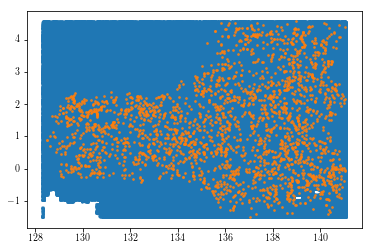

In [51]:
plt.scatter(decals_g09['RA'], decals_g09['DEC'], s=3, alpha=0.4)
plt.scatter(table_g09['ra'], table_g09['dec'], s=3, alpha=0.8)

# Oraganize the photometric results

In [77]:
# Convert the flux into magnitude 
# DECALS using AB magnitude, so mag = 22.5 - 2.5 * log10(flux)

gmag_decal = 22.5 - 2.5 * np.log10(decals_g09['DECAM_FLUX'][:,1])
rmag_decal = 22.5 - 2.5 * np.log10(decals_g09['DECAM_FLUX'][:,2])
zmag_decal = 22.5 - 2.5 * np.log10(decals_g09['DECAM_FLUX'][:,4])

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


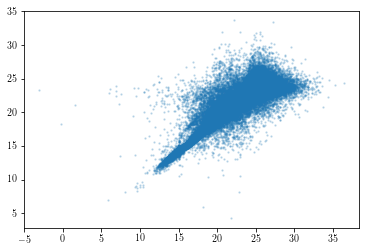

In [78]:
plt.scatter(gmag_decal, rmag_decal, s=2, alpha=0.2)

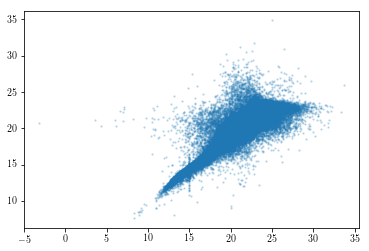

In [80]:
plt.scatter(rmag_decal, zmag_decal, s=2, alpha=0.2)

In [53]:
gflux_ivar_decal = decals_g09['DECAM_FLUX_IVAR'][:,1]
rflux_ivar_decal = decals_g09['DECAM_FLUX_IVAR'][:,2]
zflux_ivar_decal = decals_g09['DECAM_FLUX_IVAR'][:,4]

In [54]:
extinction_factor = [3.995, 3.214, 2.165, 1.592, 1.211, 1.064]

a_g_decal = decals_g09['EBV'] * extinction_factor[1]
a_r_decal = decals_g09['EBV'] * extinction_factor[2]
a_z_decal = decals_g09['EBV'] * extinction_factor[4]

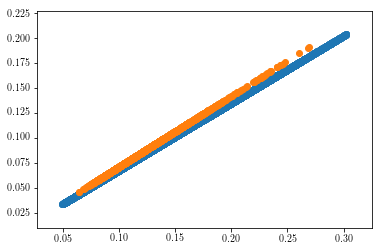

In [55]:
plt.scatter(a_g_decal, a_r_decal)
plt.scatter(table_g09['a_g'], table_g09['a_r'])

In [83]:
#columns_short = ['OBJID', 'TYPE', 'RA', 'DEC',  
#                 'DECAM_PSFSIZE', 'DECAM_FRACFLUX', 'DECAM_FRACMASKED',
#                 'DECAM_ANYMASK', 'DECAM_ALLMASK',
#                 'DCHISQ', 'FRACDEV', 
#                 'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 
#                 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2']

columns_short = ['OBJID', 'TYPE', 'RA', 'DEC',  'FRACDEV', 
                 'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 
                 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2']

decals_g09_short = decals_g09[columns_short]

In [84]:
decals_g09_short.add_column(Column(gmag_decal.data, name='gmag_decal'))
decals_g09_short.add_column(Column(rmag_decal.data, name='rmag_decal'))
decals_g09_short.add_column(Column(zmag_decal.data, name='zmag_decal'))

decals_g09_short.add_column(Column(gflux_ivar_decal.data, name='gflux_ivar_decal'))
decals_g09_short.add_column(Column(rflux_ivar_decal.data, name='rflux_ivar_decal'))
decals_g09_short.add_column(Column(zflux_ivar_decal.data, name='zflux_ivar_decal'))

decals_g09_short.add_column(Column(a_g_decal.data, name='a_g_decal'))
decals_g09_short.add_column(Column(a_r_decal.data, name='a_r_decal'))
decals_g09_short.add_column(Column(a_z_decal.data, name='a_z_decal'))

In [85]:
decals_g09_short.write('../decals/decals_dr3_g09_short.fits', format='fits', 
                       overwrite=True)